In [1]:
DATA_FILE ='../data/transportation-railroad-casualties.csv'

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
####################################################

import datetime as dt
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Useful colors to reference
SNS_BLUE, SNS_GREEN, SNS_RED, SNS_PURPLE, SNS_YELLOW, SNS_CYAN = sns.color_palette()
# sns.set_palette(sns.color_palette("cubehelix", 8))
pd.set_option('display.max_columns', 500)
plt.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

####################################################
# everett@bayesimpact.org
####################################################

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# Helpers (currently cut and paste around different notebooks... oops)

def percentify_axis(ax, which):
    which = which.lower()
    if which in ('x', 'both'):
        ax.set_xticklabels(['%.0f%%' % (t*100) for t in ax.get_xticks()])
    if which in ('y', 'both'):
        ax.set_yticklabels(['%.0f%%' % (t*100) for t in ax.get_yticks()])

color_idx = 0
CYCLE_COLORS = sns.color_palette()
def next_color():
    global color_idx
    c = CYCLE_COLORS[color_idx] 
    color_idx = (color_idx + 1) % len(CYCLE_COLORS)
    return c

def count_unique(s):
    values = s.unique()
    return sum(1 for v in values if pd.notnull(v))

def missing_pct(s):
    missing = N - s.count()
    return missing * 100.0 / N

def complete_pct(s):
    return 100 - missing_pct(s)

def summarize_completeness_uniqueness(df):
    print '*** How complete is each feature? How many different values does it have? ***'
    rows = []
    for col in df.columns:
        rows.append([col, '%.0f%%' % complete_pct(df[col]), count_unique(df[col])])
    return pd.DataFrame(rows, columns=['Column Name', 'Complete (%)','Unique Values'])

def summarize_completeness_over_time(df, time_col, transpose=True):
    print '*** Data completeness over time per column ***'
    x = df.groupby(time_col).count()
    x = x.div(df.groupby(time_col).size(), axis=0)
    for col in x.columns:
        x[col] = x[col].apply(lambda value: '%.0f%%' % (value * 100))
    if transpose:
        return x.T
    return x

def plot_top_hist(df, col, top_n=10, skip_below=.01):
    '''Plot a histogram of a categorical dataframe column, limiting to the most popular.'''
    counts = df[col].value_counts(True, ascending=True)
    if counts.max() < skip_below:
        print 'Skipping "%s" histogram -- most common value is < %.0f%% of all cases' % (col, skip_below*100)
        return
    fig, ax = plt.subplots(1)
    explanation = ''
    if len(counts) > top_n:
        explanation = ' (top %d of %d)' % (top_n, len(counts))
        counts = counts.iloc[-top_n:]
    explanation += ' -- %.0f%% missing' % (missing_pct(df[col]))
    counts.plot(kind='barh', ax=ax, color=next_color())
    ax.set_title('Rows by "%s"%s' % (col, explanation))
    ax.set_xticklabels(['%.0f%%' % (t*100) for t in ax.get_xticks()])


In [4]:
df = pd.read_csv(DATA_FILE)
print '%d rows %d columns' % df.shape
N = len(df)
df.head()

1067153 rows 49 columns


/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (4,5,6,8,9,13,16,18,28,29,31,32,33,34,35,37,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,IMO,RAILROAD,INCDTNO,TYPPERS,JOBCODE,NATINJ,LOCATION,IFATAL,OCCODE,TCODE,AGE,DAYSABS,DAYSRES,DUMMY,STATE,TYPRR,DUMMY1,REGION,DUMMY2,NARRLEN,CASFATAL,CAS57,CAS54,DUMMY3,DAY,YEAR4,TIMEHR,TIMEMIN,AMPM,COUNTY,CNTYCD,STCNTY,ALCOHOL,DRUG,PHYACT,LOCA,LOCB,LOCC,EVENT,TOOLS,INJCAUS,HZMEXPOS,TERMINAT,NARR1,NARR2,NARR3,COVERDATA,LATITUDE,LONGITUDE
0,12,YN,1275001,A,615,20,3,NaN,301,NaN,60,9,0,NaN,39,2,301,2,NaN,0,N,N,N,NaN,0,1975,0,0,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12,WSR,0012,A,313,91,NaN,NaN,875,NaN,34,0,0,X,5,2,909,5,NaN,0,N,N,N,NaN,0,1975,0,0,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,WP,2123575,D,NaN,10,5,NaN,609,NaN,0,0,0,NaN,6,2,605,7,NaN,0,N,Y,N,NaN,0,1975,0,0,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12,WP,2123375,E,NaN,30,5,NaN,902,T,57,0,0,NaN,6,2,802T,7,NaN,0,N,N,N,NaN,0,1975,0,0,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12,WP,2122075,E,NaN,70,3,NaN,701,NaN,11,0,0,NaN,6,2,701,7,NaN,0,N,N,N,NaN,0,1975,0,0,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
summarize_completeness_uniqueness(df)

*** How complete is each feature? How many different values does it have? ***


,Column Name,Complete (%),Unique Values
0,IMO,100%,12
1,RAILROAD,100%,1181
2,INCDTNO,100%,735516
3,TYPPERS,100%,10
4,JOBCODE,81%,243
5,NATINJ,100%,77
6,LOCATION,98%,20
7,IFATAL,49%,21
8,OCCODE,81%,227
9,TCODE,21%,4


In [6]:
summarize_completeness_over_time(df, 'YEAR4', transpose=False)

*** Data completeness over time per column ***


,IMO,RAILROAD,INCDTNO,TYPPERS,JOBCODE,NATINJ,LOCATION,IFATAL,OCCODE,TCODE,AGE,DAYSABS,DAYSRES,DUMMY,STATE,TYPRR,DUMMY1,REGION,DUMMY2,NARRLEN,CASFATAL,CAS57,CAS54,DUMMY3,DAY,TIMEHR,TIMEMIN,AMPM,COUNTY,CNTYCD,STCNTY,ALCOHOL,DRUG,PHYACT,LOCA,LOCB,LOCC,EVENT,TOOLS,INJCAUS,HZMEXPOS,TERMINAT,NARR1,NARR2,NARR3,COVERDATA,LATITUDE,LONGITUDE
YEAR4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1975,100%,100%,100%,100%,86%,100%,99%,12%,100%,26%,100%,100%,100%,36%,100%,100%,100%,100%,0%,100%,100%,100%,100%,0%,100%,100%,100%,0%,0%,0%,0%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1976,100%,100%,100%,100%,87%,100%,98%,12%,100%,23%,100%,100%,100%,36%,100%,100%,100%,100%,0%,100%,100%,100%,100%,0%,100%,100%,100%,0%,0%,0%,0%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1977,100%,100%,100%,100%,89%,100%,100%,12%,100%,25%,98%,100%,100%,34%,100%,100%,0%,100%,87%,100%,100%,100%,100%,0%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1978,100%,100%,100%,100%,89%,100%,100%,12%,100%,25%,97%,100%,100%,32%,100%,100%,0%,100%,91%,100%,100%,100%,100%,0%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1979,100%,100%,100%,100%,90%,100%,99%,12%,100%,24%,98%,100%,100%,31%,100%,100%,0%,100%,91%,100%,100%,100%,100%,0%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1980,100%,100%,100%,100%,90%,100%,99%,12%,100%,24%,98%,100%,100%,31%,100%,100%,0%,100%,91%,100%,100%,100%,100%,0%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1981,100%,100%,100%,100%,89%,100%,99%,12%,100%,23%,98%,100%,100%,32%,100%,100%,0%,100%,91%,100%,100%,100%,100%,0%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1982,100%,100%,100%,100%,88%,100%,98%,67%,100%,23%,98%,100%,100%,7%,100%,100%,0%,100%,92%,100%,100%,100%,100%,100%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1983,100%,100%,100%,100%,86%,100%,98%,80%,100%,26%,97%,100%,100%,7%,100%,100%,0%,100%,79%,100%,100%,100%,100%,0%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%


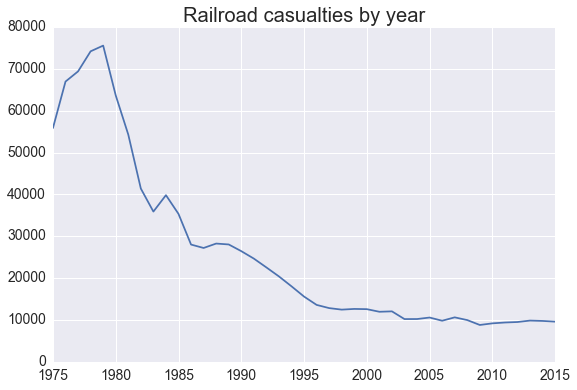

In [7]:
fig, ax = plt.subplots(1)
df['YEAR4'].value_counts().sort_index().plot(ax=ax)
ax.set_title('Railroad casualties by year')

### Note that 10,000/year is a LOT more than the "1/day" quoted by the Dept of Transportation. Maybe these rows are railroad *accidents*, not *deaths*?

#### There are a few columns that may be relevant here:

In [8]:
df[df['YEAR4'] > 2003]['CASFATAL'].value_counts(True)

N    0.908951
Y    0.091049
Name: CASFATAL, dtype: float64

In [9]:
df[df['YEAR4'] > 2003]['IFATAL'].value_counts(True)

C    0.165420
D    0.139732
B    0.120617
F    0.105602
E    0.065104
A    0.050960
G    0.041001
J    0.019448
I    0.018919
1    0.012815
H    0.010171
K    0.009097
L    0.006795
4    0.003555
6    0.002549
7    0.001646
3    0.001142
2    0.000870
8    0.000784
5    0.000145
9    0.000017
Name: IFATAL, dtype: float64

In [10]:
import gmaps

<IPython.core.display.Javascript object>

In [11]:
with_coords = df[pd.notnull(df['LATITUDE']) & pd.notnull(df['LONGITUDE']) &
                 (df['LATITUDE'] != 0) & (df['LONGITUDE'] != 0)]
coords = list(zip(with_coords['LATITUDE'], with_coords['LONGITUDE']))
gmaps.heatmap(coords)

In [12]:
print 'Year\t% incidents with Lat/Long'
for group, indices in df.groupby('YEAR4').groups.iteritems():
    frame = df.ix[indices,:]
    print '%d\t%.0f%%' % (group, pd.notnull(frame['LATITUDE']).sum() * 100.0 / len(frame))

Year	% incidents with Lat/Long
1975	0%
1976	0%
1977	0%
1978	0%
1979	0%
1980	0%
1981	0%
1982	0%
1983	0%
1984	0%
1985	0%
1986	0%
1987	0%
1988	0%
1989	0%
1990	0%
1991	0%
1992	0%
1993	0%
1994	0%
1995	0%
1996	0%
1997	0%
1998	0%
1999	0%
2000	0%
2001	0%
2002	0%
2003	36%
2004	100%
2005	100%
2006	100%
2007	100%
2008	100%
2009	100%
2010	100%
2011	100%
2012	100%
2013	100%
2014	100%
2015	100%


### Summarize ALL the things!

Skipping "INCDTNO" histogram -- most common value is < 1% of all cases
Skipping "DUMMY1" histogram -- most common value is < 1% of all cases
Skipping "NARR1" histogram -- most common value is < 1% of all cases
Skipping "NARR2" histogram -- most common value is < 1% of all cases
Skipping "NARR3" histogram -- most common value is < 1% of all cases
Skipping "COVERDATA" histogram -- most common value is < 1% of all cases


/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


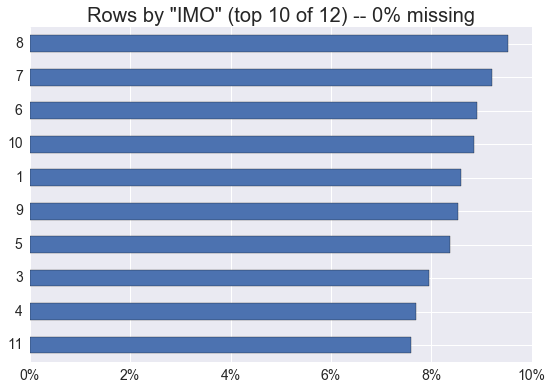

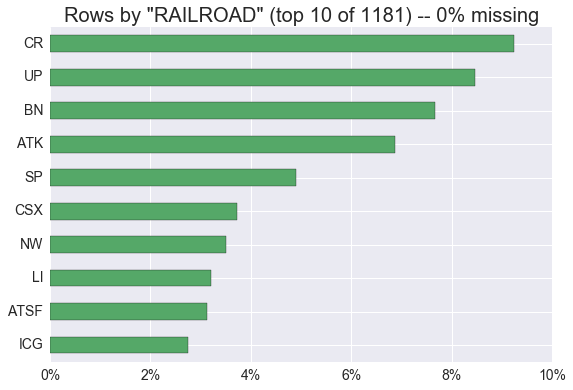

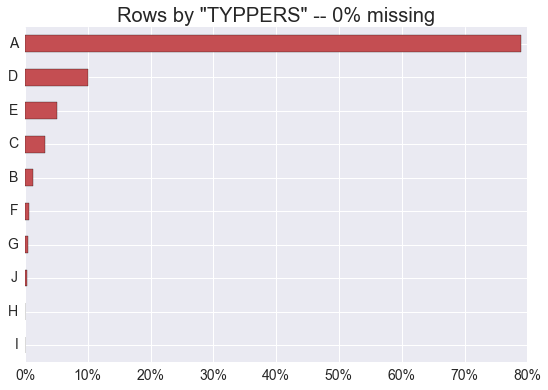

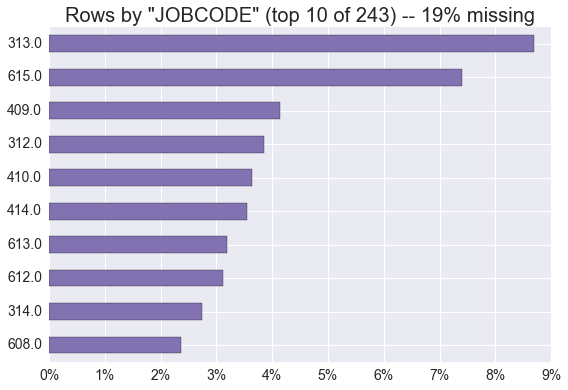

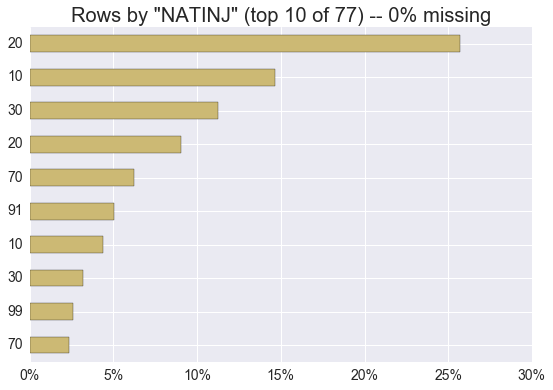

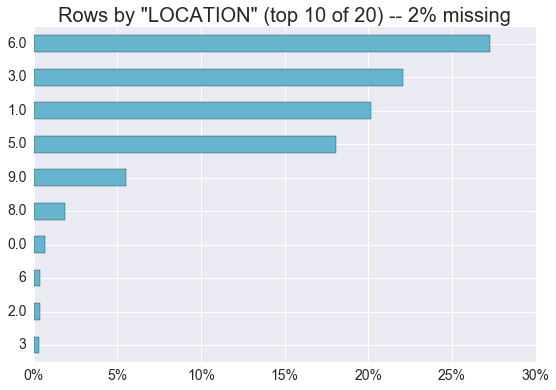

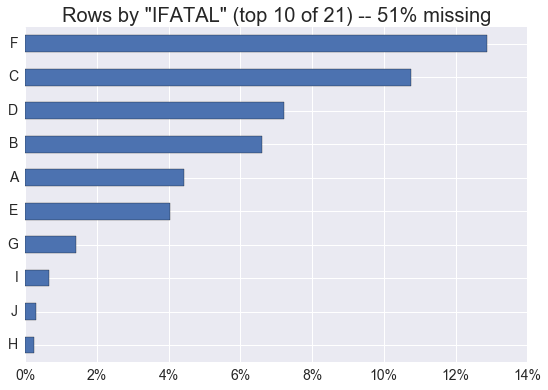

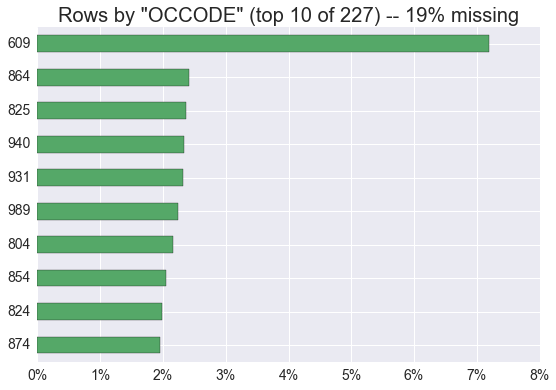

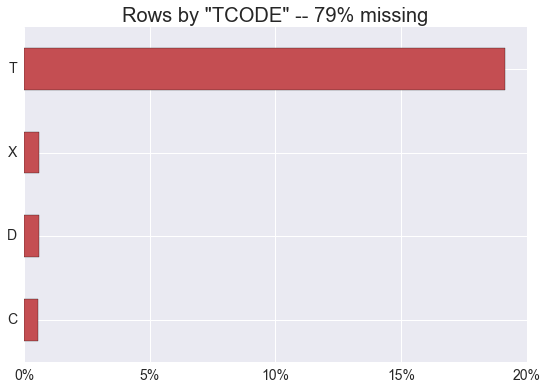

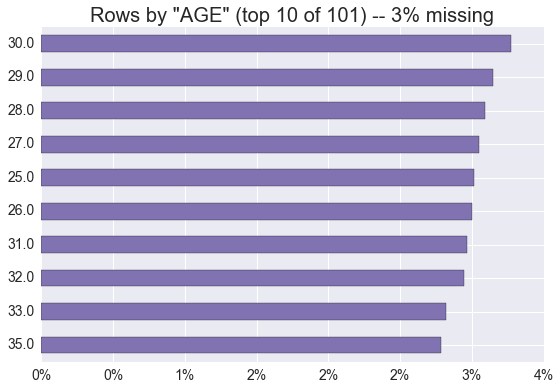

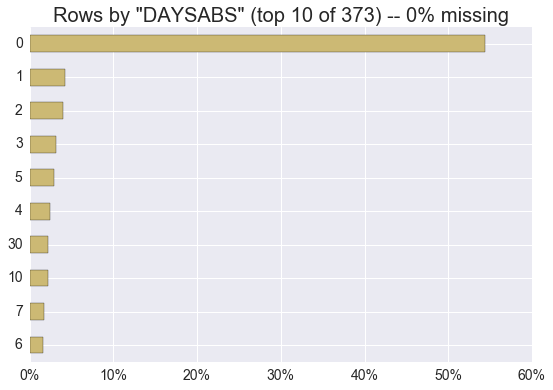

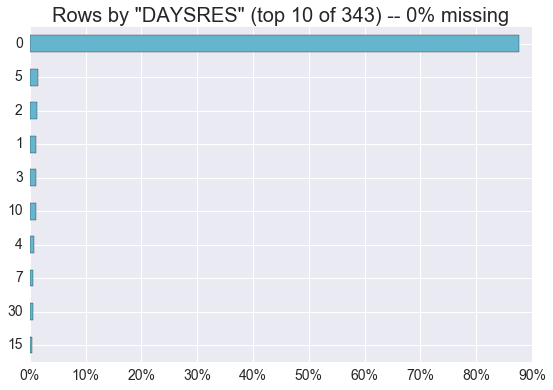

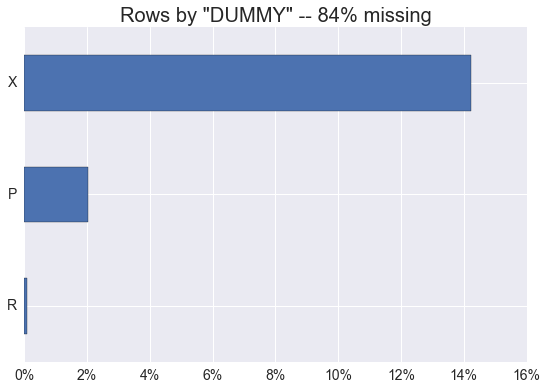

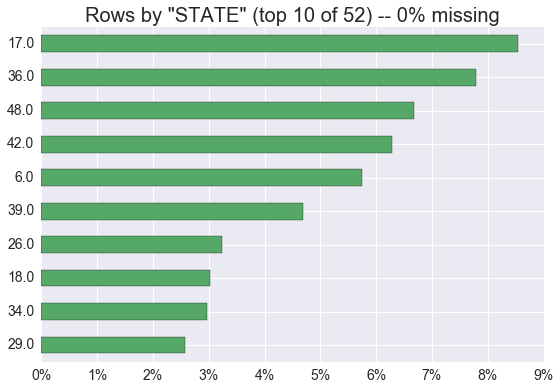

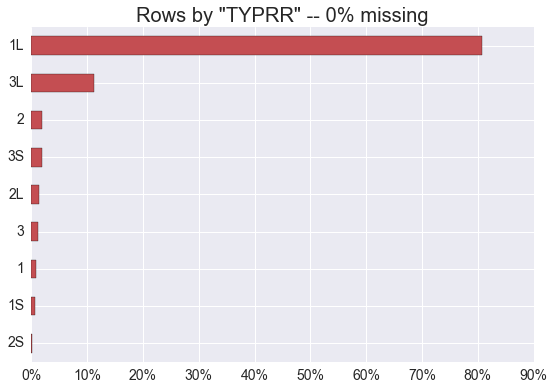

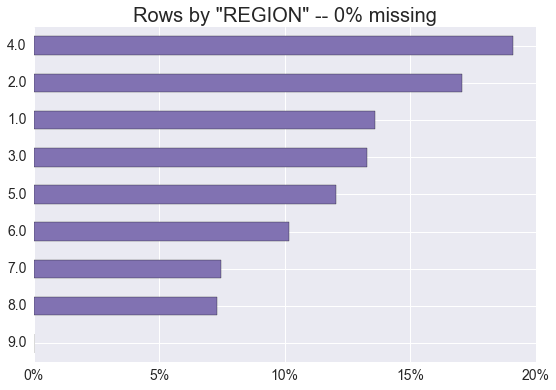

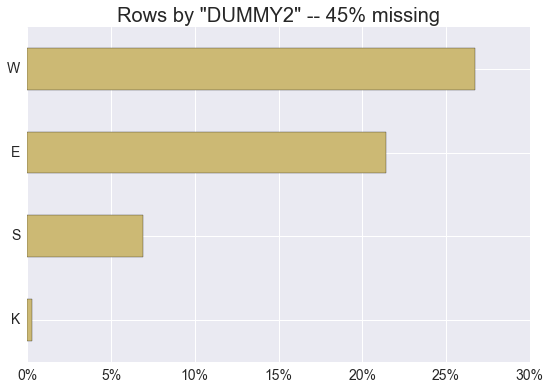

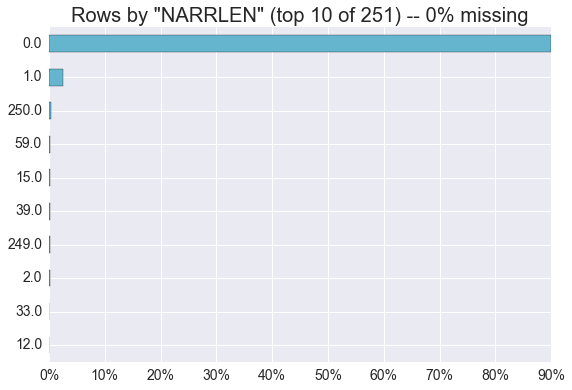

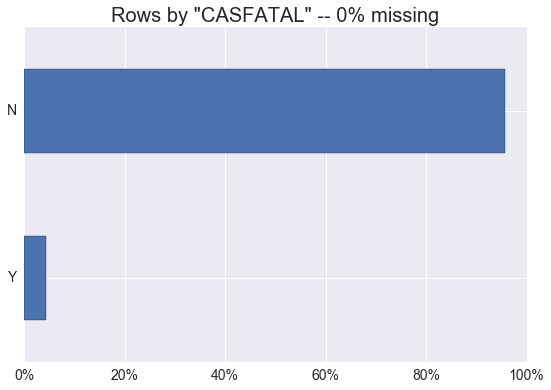

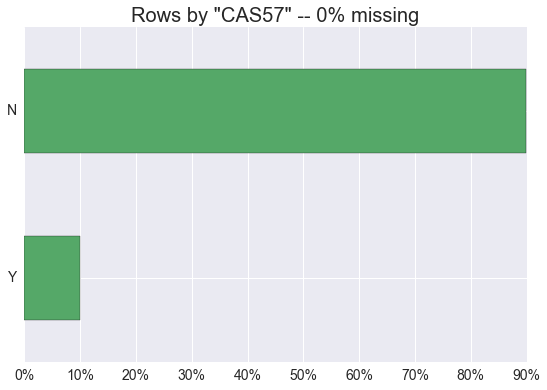

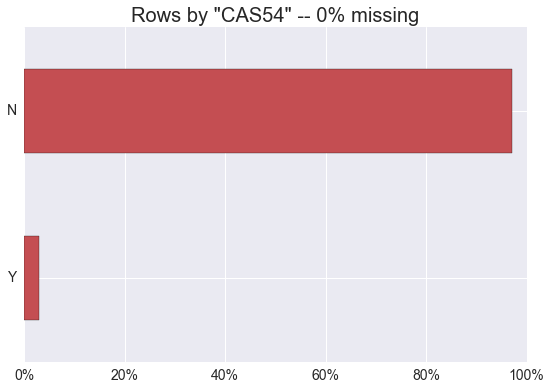

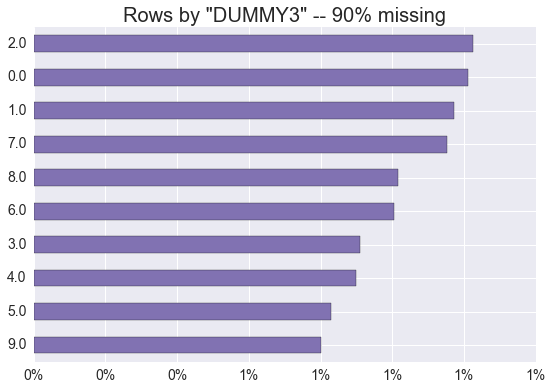

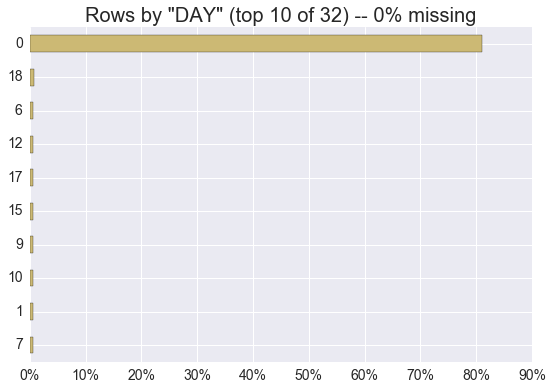

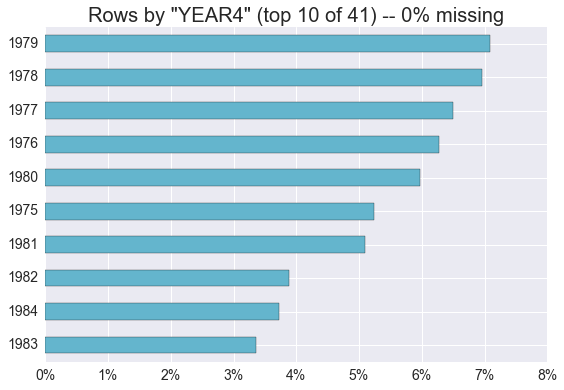

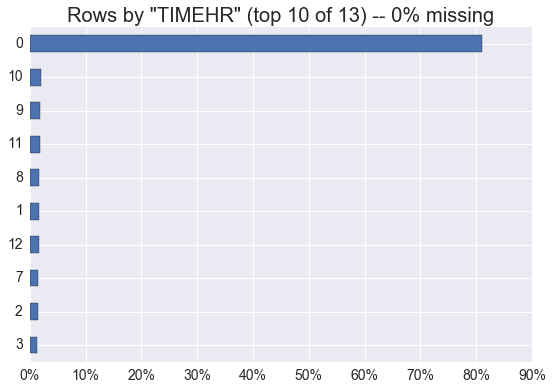

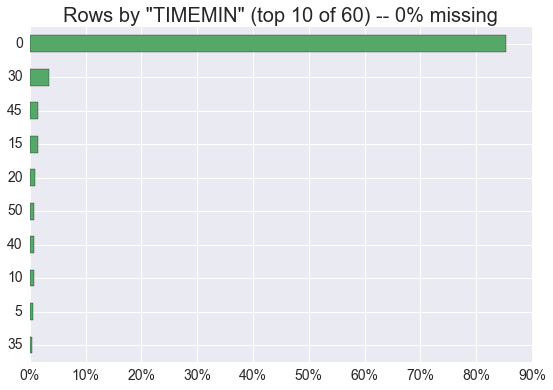

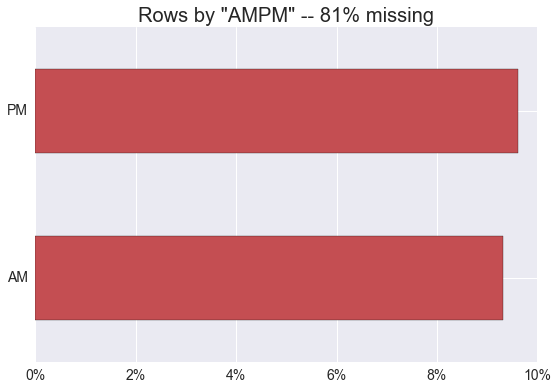

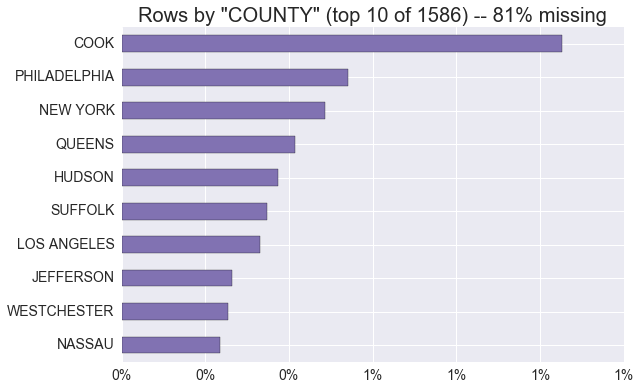

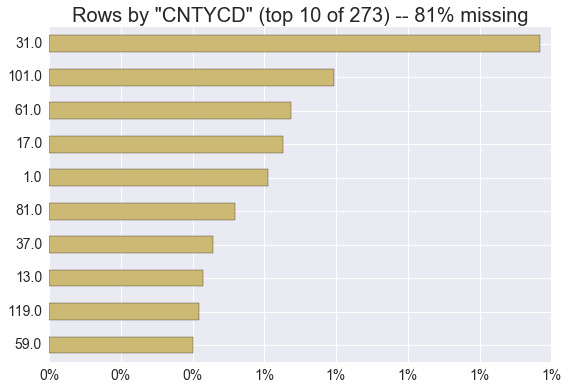

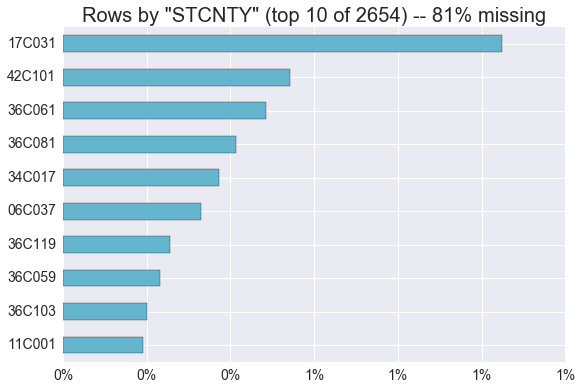

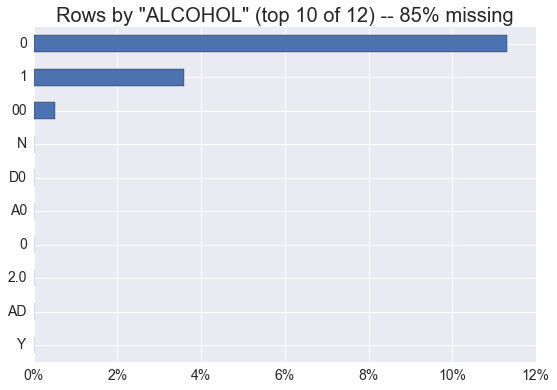

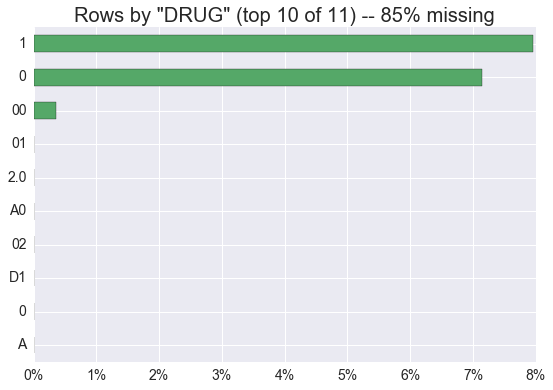

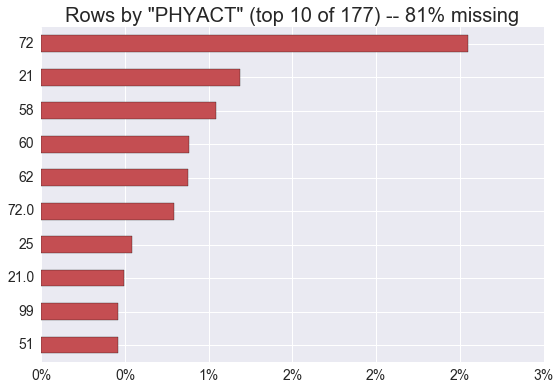

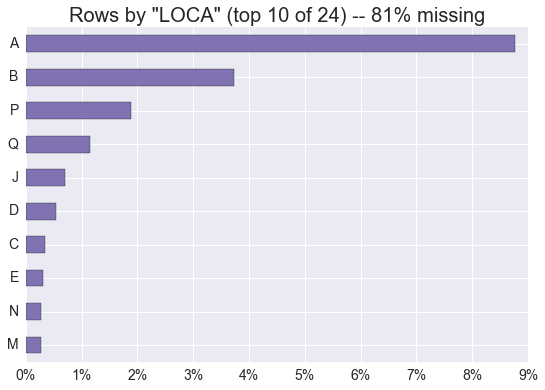

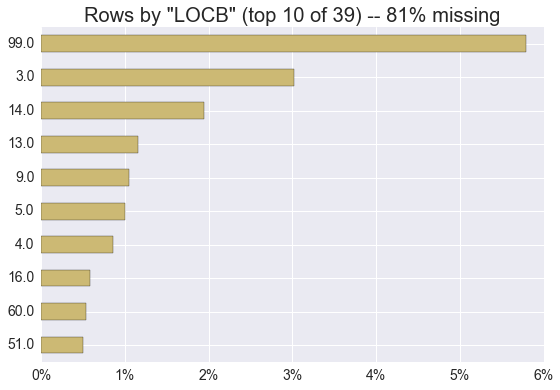

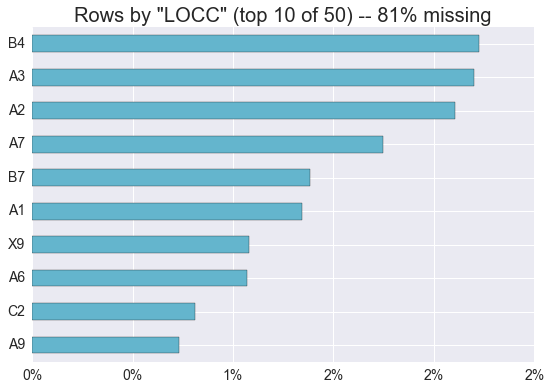

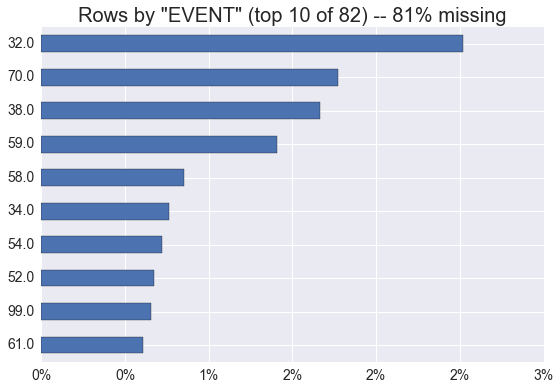

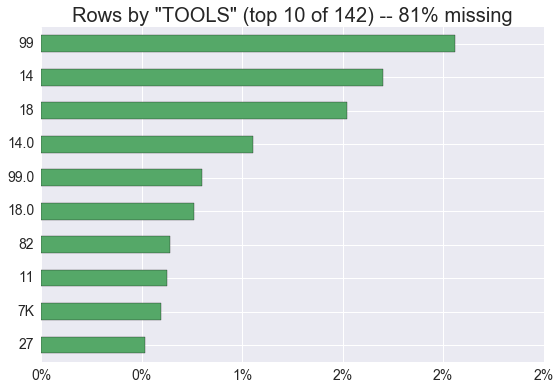

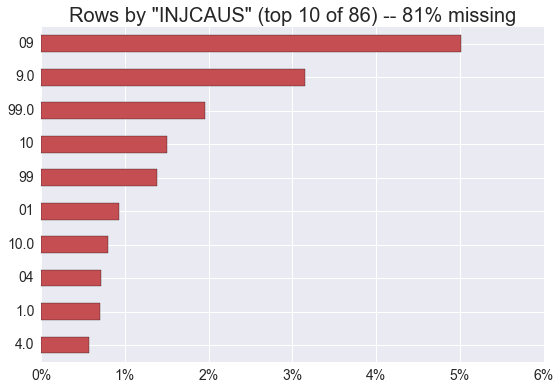

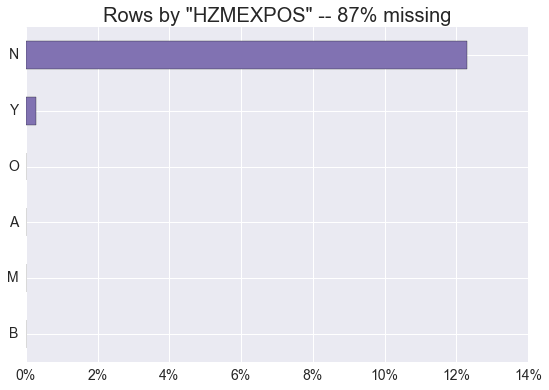

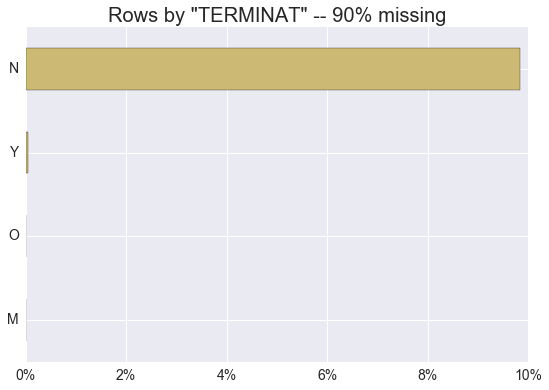

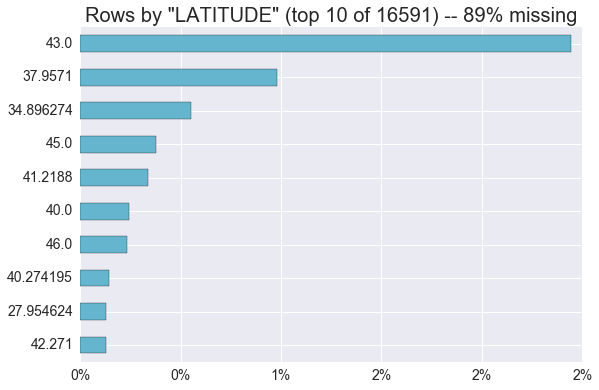

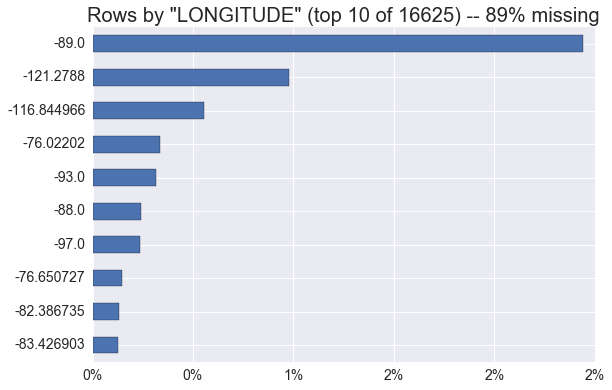

In [13]:
for col in df.columns:
    plot_top_hist(df, col)